# Introduction

In this notebook, we provide an intuitive introduction to the foundations of artificial intelligence.

**Take-aways:**
By the end of this notebook, you will have seen:
- how biological brains inspired the development of artificial neural networks in the hope that models of the brain would display emerging intelligent behaviour;
- how multi-layer perceptrons (MLPs) provide the backbone of all modern neural networks;
- and how MLPs can approximate any function (universal function approximation theorem).

In [359]:
from ipywidgets import interact, FloatSlider
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

sns.set_theme()

# 1. The Perceptron

Intuitively, one might expect artificial intelligence (AI) to arise when detailed models of the human brain are simulated on a computer. This intuition motivated the development of artificial neural networks more than 60 years ago. These artificial neural networks are now at the core of all modern AI models. In this notebook, we will retrace these early developments of artificial intelligence to better understand why language models, such as GPT3, process language the way they do.

The smallest building blocks of brains are brain cells, also known as neurons. Each neuron by itself is not more intelligent than any other cell in our body. But our brains are composed of approximately 100 billion neurons which communicate with each other and process information in a coordinated way. This is widely believed to lead to the emergence of intelligence. A good start for artificial intelligence is therefore to first build a model of a neuron, and then make many of those neurons communicate in the hope to see artificial intelligence to emerge in a similar way to biological neural networks.

In the figure below, we illustrate a human neuron in the left panel. The right panel shows a model of the neuron: an artificial neuron, commonly referred to as *perceptron*. The biological neuron consists of a junction of dendrites with the cell nucleus in the middle, and an axon leading away from the neuron. Neurons receive electrical signals through their dendrites and forward strong enough signals to other neurons along their axons. The perceptron emulates this behaviour by receiving $n$ input signals $x_1, \ldots, x_n$ which are processed into one output signal $y$.

<img src="biological-neuron.jpg" width="500" style="display: block; margin: 0 auto" >

More specifically, we may define a perceptron using a linear combination of the input signals and a step function that only returns a value of $1$ when the weighted sum is greater than zero 

$$
y = f(x, w) = \Theta (w_0\, x_0 + \ldots + w_n\, x_n),
$$
where $\Theta(z) = 1$ for $z>0$, and $\Theta(y) = 0$ otherwise. This activation function, $\Theta(z)$, mimics the behaviour of neurons to only forward signals if the incoming signals are large enough.

### Task 1: Implement a simple artificial neuron

To familiarise yourselfves with how perceptrons process information, implement a perceptron by completing the code block below. When you are ready, use the notebook cell after that to test your implementation.

In [2]:
def perceptron(x):
    """
    Returns the output of a perceptron with 6 input signals.

    Parameters:
        x (List of length 6) Input signals to the perceptron.
    """
    weights = [0.2, -0.3, 0.9, 0.4, -0.9, -0.5]

    # TODO: Calculate y
    z = np.sum(np.array(weights) * np.array(x))

    # Calculate activation
    if z > 0:
        return 1

    return 0

<span style="color: red;">TODO:</span> Need simple checks of the solutions where the function is checked against the correct outputs? Last time I did this for example by pre-implementing the correct solution in a module, see In [6] in https://github.com/equinor/edc2023-optimising-wind-farms/blob/main/03_wind_farm_model/solution.ipynb.

In [ ]:
# Solution

## 2 From single perceptrons to networks of perceptrons

Without activation functions, single perceptrons are mathematically equivalent to linear regression models (which have been used in the machine learning community already for a very long time)

$$
    z = \sum _{j=1}^n w_j x_j.
$$

For just two inputs, this makes it possible to visualise the outputs of perceptrons for different input values using straight lines in a plane, see below. Note that it is convential to consider $x_0$ to be fixed to one, $x_0=1$. This enables translations of the lines in the plane. The corresponding weight, $w_0$, is commonly referred to as the bias of the perceptron. 

<img src="linear_classifier.png" width="500" style="display: block; margin: 0 auto">

The interpretation of perceptrons as binary linear regressors, i.e. linear classifiers, makes intuitively clear how the smallest building blocks of artificial neural networks process information. But one perceptron alone is limited in what it can do and certainly does not achieve artificial "intelligence".

To visualise the limitations of a single perceptron, let us attempt a simple 2-dimensional classification task using the perceptron.

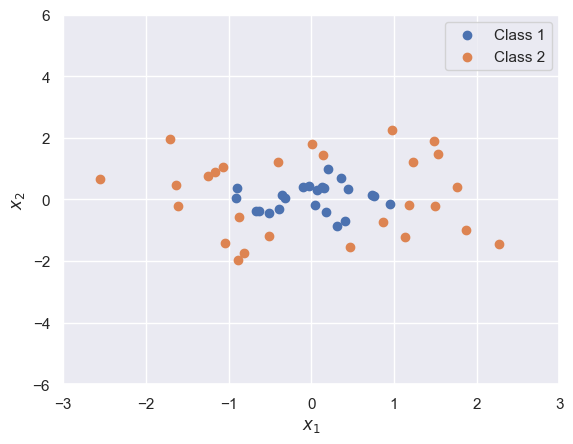

In [37]:
# Generate random data
np.random.seed(0)
n_samples = 50
X = np.random.randn(n_samples, 2)
y = np.zeros(n_samples)
y[np.linalg.norm(X, axis=1) > 1] = 1

# Plot the data
plt.scatter(X[y==0, 0], X[y==0, 1], label='Class 1')
plt.scatter(X[y==1, 0], X[y==1, 1], label='Class 2')

plt.xlim(-3, 3)
plt.ylim(-6, 6)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.legend()
plt.show()

Here, the task for the perceptron is to classify the points based on the $x_1$ and $x_2$ coordinates. It is clear that we will not be able to use just a single line to separate the blue dots from the orange dots. But, we could, perhaps, use 4 perceptrons to classify the data...

### Task 2: Find 4 perceptrons that can jointly classify the data points
For example, you could decide that a data point is classified as "blue" if all perceptrons return a 1. Otherwise the data point is classified as orange. You can use the below code block to define the weights of the perceptrons, and the code block after that to visualise their decision boundaries.

In [59]:
# TODO
perceptron1 = {
    'bias': -2,
    'weight1': 2,
    'weight2': 1
}
perceptron2 = {
    'bias': -2,
    'weight1': -1,
    'weight2': 2
}
perceptron3 = {
    'bias': -2,
    'weight1': -2,
    'weight2': -1
}
perceptron4 = {
    'bias': -3,
    'weight1': 2,
    'weight2': -2
}

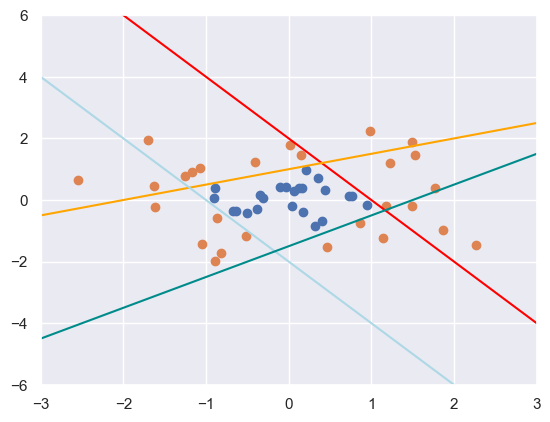

In [60]:
# Plot the data
plt.scatter(X[y==0, 0], X[y==0, 1])
plt.scatter(X[y==1, 0], X[y==1, 1])

# linear classifications
x1 = np.linspace(-3, 3, 100)
x2 = -(perceptron1['weight1'] * x1 + perceptron1['bias']) / perceptron1['weight2']
plt.plot(x1, x2, linestyle='-', color='red')

x2 = -(perceptron2['weight1'] * x1 + perceptron2['bias']) / perceptron2['weight2']
plt.plot(x1, x2, linestyle='-', color='orange')

x2 = -perceptron3['weight1'] / perceptron3['weight2'] * x1 - perceptron3['bias'] / perceptron3['weight2']
plt.plot(x1, x2, linestyle='-', color='lightblue')

x2 = -perceptron4['weight1'] / perceptron4['weight2'] * x1 - perceptron4['bias'] / perceptron4['weight2']
plt.plot(x1, x2, linestyle='-', color='darkcyan')

plt.xlim(-3, 3)
plt.ylim(-6, 6)
plt.show()

This exercise demonstrates that networks of artificial neurons can perform more complex tasks than single perceptrons. The figure below illustrates this network diagrammatically.

<img src="complex_classifier_perceptron_diagram.png" width="1000" style="display: block; margin: 0 auto">

However, so far our neural network does not feel very "intelligent". It can only classify points in a plane, and we had to painfully tweak the weights of the network to do it. More complex networks are able to perform more complex tasks (modern neural networks, such as large language models, have up to 200 billion model weights), but we need to find a way to avoid manually tweaking the weights of network networks.

## 3 Training neural networks

The automatic tweaking of neural network weights is achieved using numerical optimisation algorithms and is referred to as "training" or as "learning" in the AI community. While "training" and "learning" sounds fancy, the high level concept of automatically tweaking network weights to optimise an objective is quite intuitive...

### Task 3: Discuss in your group how you would design an iterative 3-step algorithm that can optimise neural network weights

Complete the below algorithm:

For iteration in range(n_iterations):

1. Do ... Propose weights

2. Do ... Evaluate objective

3. Do ... Accept or reject weights


Did you come across any numerical optimisers before?

A simple, though not very efficient way to train neural networks is to repeatedly sample random weights from a distribution of possible model weights and test whether any of them satisfy our objective using an objective function. In this case, the objective is to classify all points in the dataset correctly. So, the network should assign blue points with the class label "0" and orange points with the class label "1". A simple metric to quantify how well our network does this is to simply count the number of points that the network classifies incorrectly for a given set of model weights

$$
\text{Loss}(w) = \sum _{j=1}^n y_j(1-f(x_i, w)) + \sum _{j=1}^n (1 - y_j)f(x_i, w).
$$

The optimisation algorithm would then repeatedly: 1. sample model parameters; 2. evaluate the objective function / loss for those model parameters; and 3. accept the model parameters if the loss is lower than before. Let us test how well this stochastic optimisation algorithm does!

### Task 4: Implement the objective function / loss function
You can use the implementation of the neural network below. Use the pre-implemented checks to test your solution. 

In [72]:
def perceptron(inputs, weights):
    """
    Returns the output of a perceptron with 3 input signals.

    Parameters:
        inputs (np.ndarray of shape (2, n)) Input data.
        weights (np.ndarray of shape (3,)) Weights of the network.
    """
    # Calculate linear output
    z = weights[0] + weights[1] * inputs[0] + weights[2] * inputs[1]

    # Calculate activation
    y = np.array(z > 0, dtype=float)

    return y


def neural_network(inputs, weights):
    """
    Returns the output of the simple neural network.

    Parameters:
        inputs (np.ndarray of shape (2, n)) Input data.
        weights (np.ndarray of shape (12,)) Weights of the network.
    """
    inputs = np.array(inputs)
    weights = np.array(weights)

    # Parse weights
    weights1 = weights[:3]
    weights2 = weights[3:6]
    weights3 = weights[6:9]
    weights4 = weights[9:12]

    # Process data
    n = inputs.shape[1]
    out = np.empty(shape=(4, n))
    for idw, w in enumerate([weights1, weights2, weights3, weights4]):
        out[idw] = perceptron(inputs, w)

    # If all perceptrons predict a 0, the label is a zero. Otherwise 1
    y = np.sum(out, axis=0)
    y[y > 0] = 1

    return y


In [73]:
# TODO Complete the implementation of the loss function

# We regenerate the data, just in case X was overwritten
np.random.seed(0)
n_samples = 50
X = np.random.randn(n_samples, 2)
y = np.zeros(n_samples)
y[np.linalg.norm(X, axis=1) > 1] = 1

def loss_function(weights):
    y_pred = neural_network(inputs=X.T, weights=weights)

    mask0 = y == 0
    mask1 = y == 1

    loss = np.sum(1 - y_pred[mask1]) + np.sum(y_pred[mask0])

    return loss


Test your implementation:

In [108]:
weights = np.array([-2, 2, 1, -2, -1, 2, -2, -2, -1, -3, 2, -2])
assert loss_function(weights) == 0

weights += 1
assert loss_function(weights) == 15

weights -= 2
assert loss_function(weights) == 11

### Task 5: Train our neural network so it "learns" how to classify the points by itself

The cell below implements the optimisation algortihm that we have discussed, using the loss function. Execute it to train the model. 

The code will produce plots to visualise the training: 1. the evolution of the loss over the iterations of the optimisation; and 2. the final classification, learned by the neural network. Do the results make sense to you?

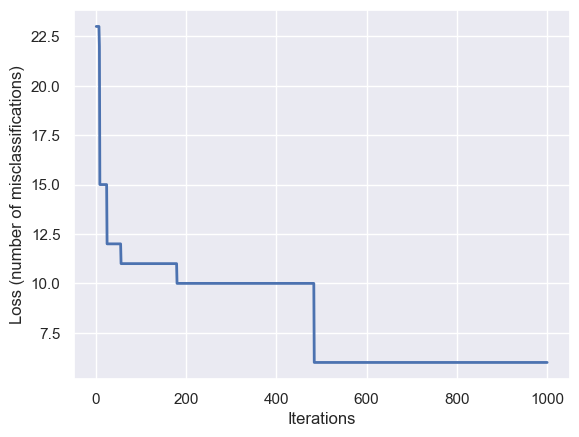

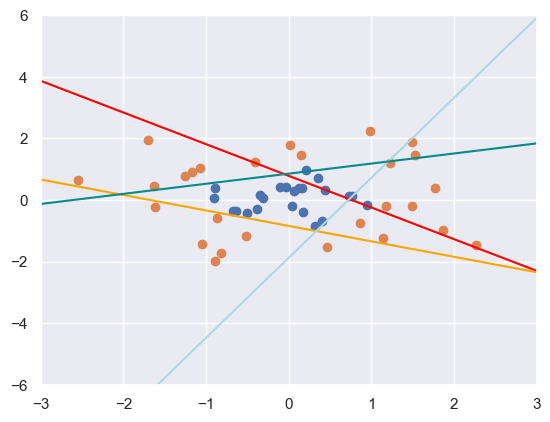

In [354]:
# Training
np.random.seed(42)
n_iterations = 1000
losses = np.empty(n_iterations)
for n in range(n_iterations):
    # Sample proposal
    proposal = np.random.uniform(low=-3, high=3, size=12)
    loss = loss_function(proposal)

    # Accept on first iteration
    if n == 0:
        weights = proposal
        losses[n] = loss
        continue

    # Check whether loss is lower than for previous parameters
    isProposalAccepted = loss < losses[n-1]
    if isProposalAccepted:
        weights = proposal
        losses[n] = loss
    else:
        # We did not accept, so loss remains the same
        losses[n] = losses[n-1]


# Visualise loss over time
iterations = np.arange(1, n_iterations+1)
plt.plot(iterations, losses, linewidth=2)
plt.xlabel('Iterations')
plt.ylabel('Loss (number of misclassifications)')
plt.show()

# Visualise the learned classification
plt.scatter(X[y==0, 0], X[y==0, 1])
plt.scatter(X[y==1, 0], X[y==1, 1])

x1 = np.linspace(-3, 3, 100)
x2 = -(weights[1] * x1 + weights[0]) / weights[2]
plt.plot(x1, x2, linestyle='-', color='red')
x2 = -(weights[4] * x1 + weights[3]) / weights[5]
plt.plot(x1, x2, linestyle='-', color='orange')
x2 = -(weights[7] * x1 + weights[6]) / weights[8]
plt.plot(x1, x2, linestyle='-', color='lightblue')
x2 = -(weights[10] * x1 + weights[9]) / weights[11]
plt.plot(x1, x2, linestyle='-', color='darkcyan')

plt.xlim(-3, 3)
plt.ylim(-6, 6)
plt.show()

That is amazing! Our neural network learned to classify most of the data points all by itself! Why do you think did it not manage to classify all points perfectly?

# 4 Other activation functions for better training

In the above example, we trained a neural network using a simple optimisation algorithm that randomly samples weights from a distribution. This optimiser is guaranteed to evenutally find the optimal set of model parameters for our objective, the only problem is that it can take a veeeery large number of iterations to randomly sample this set of model parameters from the distribution. Common practice is therefore to use more advanced optimisers that take more information from the loss function into account to solve the optimisation task.

The most popular among those optimisers is the gradient descent (GD) algorithm which uses local derivatives of the loss function to step into the direction of its steepest descent. We will use pre-implemented versions of the GD algorithm in the remainder of this workshop 

However, before we do so, we still have one amendment to make to the action functions that we have used so far. Can you think of the reason why? 

**Aside:** Note that the GD optimiser is no longer guaranteed to find the globally optimal network weights. Discussing this is beyond this workshop. But if you are interested, have a look at this optimisation workshop: https://github.com/equinor/edc2023-optimising-wind-farms

### Task 6: Why will a GD algorithm not be able to optimise our neural network?

Look at the visualisation of the activation function below and discuss in your group why the GD algorithm might struggle to optimise networks that use this activation function.

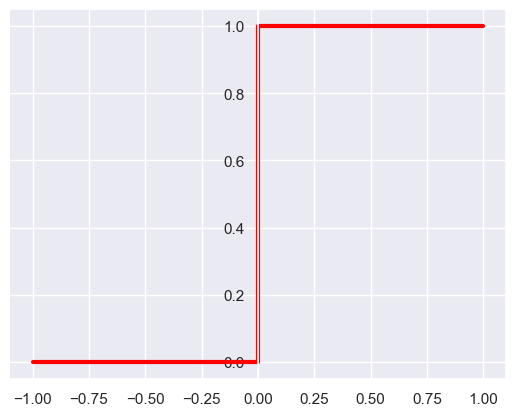

In [109]:
x = [-1, 0, 1]
y = [0, 0, 1]

fig, ax = plt.subplots()
ax.step(x, y, color='red', linewidth=3)

# Move the y-axis ticks to the center
ax.spines['left'].set_position('center')
plt.show()

Hint: How does the output of the activation function change for different inputs? And what does that mean for the gradients of the loss function?

When you are ready, execute the cell below for a visualisation of the gradient.

### Task 7: Execute the cell below and use the slider in the figure to visualise how the gradient changes.

In [112]:
def step_function(x):
    return np.where(x > 0, 1, 0)

def step_function_gradient(x):
    return 0

# Define the function to plot
def plot_sine(delta_z):
    my_dpi = 192
    fig = plt.figure(figsize=(2250 // my_dpi, 900 // my_dpi), dpi=150)
    outer = gridspec.GridSpec(1, 2, hspace=0.6)

    # Create axes
    axes = []
    axes.append(plt.Subplot(fig, outer[0]))
    axes.append(plt.Subplot(fig, outer[1]))

    # Add axes to figure
    for ax in axes:
        fig.add_subplot(ax)

    # plot step function
    x = [-0.55, 0, 0.45]
    y = [0, 0, 1]
    axes[0].step(x, y, color='black', linewidth=3)
    axes[1].plot(x, [0, 0, 0], color='black', linewidth=3)

    # plot the starting point
    z0 = -0.05
    z = z0 + delta_z
    axes[0].plot(z0, step_function(z0), 'ro', markerfacecolor='none')
    axes[0].text(z0, step_function(z0) - 0.2, rf'$z_0 = {z0}$', fontsize=12, ha='center')
    axes[1].plot(z0, step_function_gradient(z0), 'ro', markerfacecolor='none')
    axes[1].text(z0, step_function_gradient(z0) - 0.2, rf'$z_0 = {z0}$', fontsize=12, ha='center')

    # plot the moving point
    axes[0].plot(z, step_function(z), 'ro')
    axes[0].text(z, step_function(z) + 0.2, rf'$z = z_0 + \Delta z = {z:.2f}$', fontsize=12, ha='right')
    axes[1].plot(z, step_function_gradient(z), 'ro')
    axes[1].text(z, step_function_gradient(z) + 0.2, rf'$z = z_0 + \Delta z = {z:.2f}$', fontsize=12, ha='right')

    axes[0].set_ylim([-1, 2])
    axes[0].set_xlabel(r'$z = \mathbf{w \cdot x}$')
    axes[0].set_ylabel(r'$f(z)$')
    axes[0].set_title('Output of perceptron')

    axes[1].set_ylim([-1, 2])
    axes[1].set_xlabel(r'$z = \mathbf{w \cdot x}$')
    axes[1].set_ylabel(r'$\partial f(z) / \partial w_j$')
    axes[1].set_title('Gradient of perceptron')
    plt.show()

# Create the slider
slider = FloatSlider(min=-0.15, max=0.5, step=0.01, value=0)

# Create the interactive plot
func = interact(plot_sine, delta_z=slider)

interactive(children=(FloatSlider(value=0.0, description='delta_z', max=0.5, min=-0.15, step=0.01), Output()),…

The gradient of the activation function with respect to the model weights is practically zero everywhere (it is infinite exactly at z = 0)! As a result, also the gradient of the loss function with respect to the weights is practically zero everywhere. This makes the use of the GD algorithm for our network impossible.

### 4.1 The sigmoid activation function

To avoid this "vanishing gradients" problem, it is common to use other activation functions to improve the learning of neural networks. One of those activation functions is the sigmoid activation function illustrated below.

In [122]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_gradient(x):
    return np.exp(-x) / (1 + np.exp(-x))**2

# Define the function to plot
def plot_sine(delta_z):
    my_dpi = 192
    fig = plt.figure(figsize=(2250 // my_dpi, 900 // my_dpi), dpi=150)
    outer = gridspec.GridSpec(1, 2, hspace=0.6)

    # Create axes
    axes = []
    axes.append(plt.Subplot(fig, outer[0]))
    axes.append(plt.Subplot(fig, outer[1]))

    # Add axes to figure
    for ax in axes:
        fig.add_subplot(ax)

    # Plot reference
    x = np.linspace(-20, 20, 100)
    axes[0].plot(x, sigmoid(x), color='black', linewidth=3)
    axes[1].plot(x, sigmoid_gradient(x), color='black', linewidth=3)

    # plot the starting point
    z0 = -5
    z = z0 + delta_z
    axes[0].plot(z0, sigmoid(z0), 'ro', markerfacecolor='none')
    axes[0].text(z0, sigmoid(z0) - 0.2, rf'$z_0 = {z0}$', fontsize=12, ha='center')
    axes[1].plot(z0, sigmoid_gradient(z0), 'ro', markerfacecolor='none')
    axes[1].text(z0, sigmoid_gradient(z0) + 0.02, rf'$z_0 = {z0}$', fontsize=12, ha='center')

    # plot the moving point
    axes[0].plot(z, sigmoid(z), 'ro')
    axes[0].text(z, sigmoid(z) + 0.2, rf'$z = z_0 + \Delta z = {z:.2f}$', fontsize=12, ha='right')
    axes[1].plot(z, sigmoid_gradient(z), 'ro')
    axes[1].text(z, sigmoid_gradient(z) + 0.02, rf'$z = z_0 + \Delta z = {z:.2f}$', fontsize=12, ha='right')

    axes[0].set_ylim([-0.5, 1.5])
    axes[0].set_title(rf'Impact of changing $z$ on activation')
    plt.show()

# Create the slider
slider = FloatSlider(min=-7, max=15, step=0.1, value=0)

# Create the interactive plot
func = interact(plot_sine, delta_z=slider)

interactive(children=(FloatSlider(value=0.0, description='delta_z', max=15.0, min=-7.0), Output()), _dom_class…

The sigmoid activation function is almost the same as the step activation function that we have used before, the only differences is that the change from an output equal to 0 to an output equal to 1 now happens smoothly, avoiding the vashing gradients (at least for z-values close to 0). Formally, the sigmoid activation can be written as

$$
a = \sigma (z) = \frac{1}{1 + e^{-z}}.
$$

In modern neural networks, many other activation functions are also used. Below we just show a random selection of these activation functions.

$$
\tanh(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}
$$
$$
\frac{d}{dx}\tanh(x) = 1 - \tanh^2(x)
$$
$$
\text{Swish}(x) = x \cdot \frac{1}{1 + e^{-\beta x}}
$$
$$
\text{ELU}(x) = \begin{cases} x, & \text{if } x > 0 \\ \alpha (e^x - 1), & \text{otherwise} \end{cases}
$$

### Task 8: Train the neural network again using the GD algorithm

Below, we have prepared an implementation of our neural networks using PyTorch (one of the most popular deep learning frameworks in Python). Execute the cell, and compare the result obtained with the GD optimiser to the previously obtained classifier.

In [345]:
class NeuralNetwork(nn.Module):
    def __init__(self, n_inputs=2, n_perceptrons=4):
        super(NeuralNetwork, self).__init__()
        self.layer = nn.Linear(n_inputs, n_perceptrons, dtype=torch.float64)

    def forward(self, x):
        # Perceptron activation (now using sigmoid)
        out = F.sigmoid(self.layer(x))

        # Joint decision of perceptrons
        out = torch.sum(out, axis=1)
        y = F.sigmoid(out)

        # A little hacky: y is now between 0.5 and 1. Recenter to 0 to 1
        y = (y - 0.5) * 2

        return y

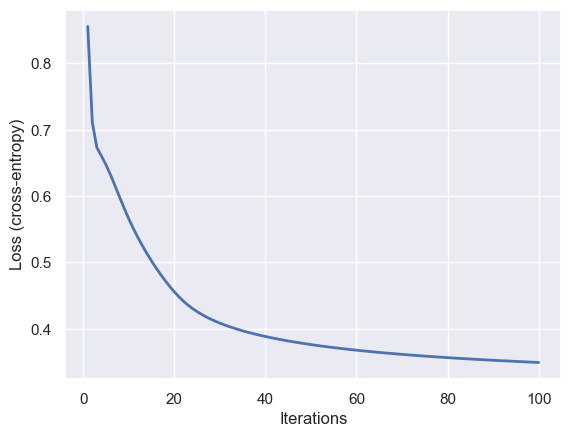

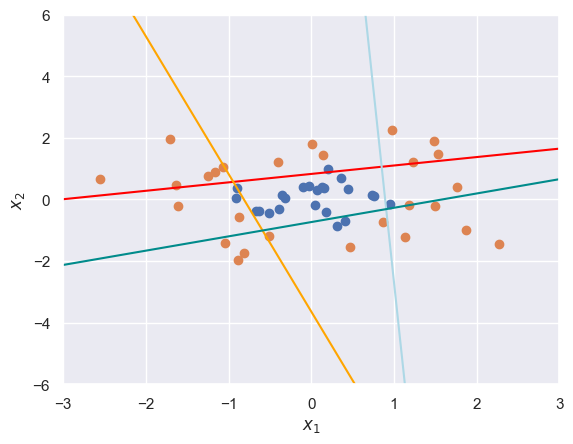

In [352]:
# Set up optimisation
torch.manual_seed(8)
model = NeuralNetwork()
objective_function = nn.BCELoss()
optimiser = optim.SGD(model.parameters(), lr=10)

# We regenerate the data, just in case X was overwritten
np.random.seed(0)
n_samples = 50
X = np.random.randn(n_samples, 2)
y = np.zeros(n_samples)
y[np.linalg.norm(X, axis=1) > 1] = 1
inputs = torch.tensor(X)
labels = torch.tensor(y)

# Run optimisation
losses = []
n_iterations = 100
for epoch in range(n_iterations):
    # Reset the parameter gradients
    optimiser.zero_grad()

    # Simulation, evaluation and parameter proposal
    outputs = model(inputs)
    loss = objective_function(outputs, labels)
    loss.backward()
    optimiser.step()

    losses.append(loss.detach().numpy())

# Visualise loss over time
iterations = np.arange(1, n_iterations+1)
plt.plot(iterations, losses, linewidth=2)
plt.xlabel('Iterations')
plt.ylabel('Loss (cross-entropy)')
plt.show()

# Visualise the learned classification
plt.scatter(X[y==0, 0], X[y==0, 1])
plt.scatter(X[y==1, 0], X[y==1, 1])

# Reshape model weights
weights = np.empty(12)
bias = model.layer.bias.detach().numpy()
weights = model.layer.weight.detach().numpy()

x1 = np.linspace(-3, 3, 100)
x2 = -(weights[0, 0] * x1 + bias[0]) / weights[0, 1]
plt.plot(x1, x2, linestyle='-', color='red')
x2 = -(weights[1, 0] * x1 + bias[1]) / weights[1, 1]
plt.plot(x1, x2, linestyle='-', color='orange')
x2 = -(weights[2, 0] * x1 + bias[2]) / weights[2, 1]
plt.plot(x1, x2, linestyle='-', color='lightblue')
x2 = -(weights[3, 0] * x1 + bias[3]) / weights[3, 1]
plt.plot(x1, x2, linestyle='-', color='darkcyan')

plt.xlim(-3, 3)
plt.ylim(-6, 6)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.show()

Number of incorrectly classified points:

In [355]:
mask0 = y == 0
mask1 = y == 1
y_pred = model(inputs).detach().numpy()
n_misclassified = np.sum(1 - np.round(y_pred[mask1])) + np.sum(np.round(y_pred[mask0]))
n_misclassified

6.0

The GD optimiser finds a good set of network weights much faster than the stochastic optimiser, but it still fails to find the optimal arrangement of the decision boundaries -- even if we run the optimiser for many more iterations (try it!). Can you think of a reason why? 

One way to improve the performance of the network is to add more perceptrons to it. This creates more local minima which are able to classify the data points perfectly.

### Task 9: Retrain the network with more perceptrons

Amend the network below, so that it uses 10 perceptrons for the classification instead of 4.

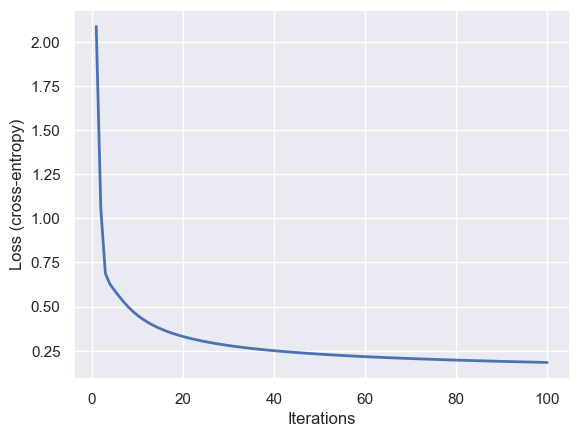

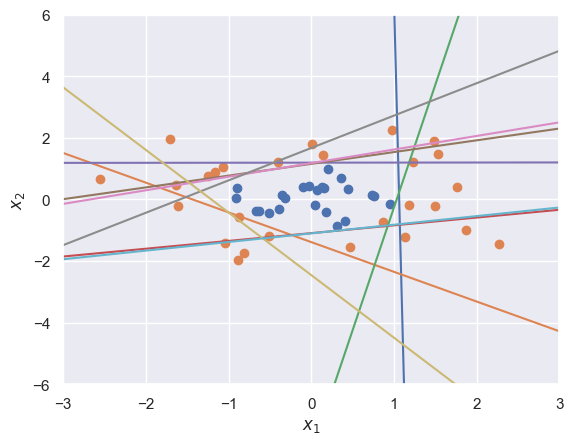

In [357]:
# TODO: Set the number of perceptrons and execute the cell
n_perceptrons = 10

# Set up optimisation
torch.manual_seed(8)
model = NeuralNetwork(n_perceptrons=n_perceptrons)
objective_function = nn.BCELoss()
optimiser = optim.SGD(model.parameters(), lr=10)

# We regenerate the data, just in case X was overwritten
np.random.seed(0)
n_samples = 50
X = np.random.randn(n_samples, 2)
y = np.zeros(n_samples)
y[np.linalg.norm(X, axis=1) > 1] = 1
inputs = torch.tensor(X)
labels = torch.tensor(y)

# Run optimisation
losses = []
n_iterations = 100
for epoch in range(n_iterations):
    # Reset the parameter gradients
    optimiser.zero_grad()

    # Simulation, evaluation and parameter proposal
    outputs = model(inputs)
    loss = objective_function(outputs, labels)
    loss.backward()
    optimiser.step()

    losses.append(loss.detach().numpy())

# Visualise loss over time
iterations = np.arange(1, n_iterations+1)
plt.plot(iterations, losses, linewidth=2)
plt.xlabel('Iterations')
plt.ylabel('Loss (cross-entropy)')
plt.show()

# Visualise the learned classification
plt.scatter(X[y==0, 0], X[y==0, 1])
plt.scatter(X[y==1, 0], X[y==1, 1])

# Reshape model weights
weights = np.empty(n_perceptrons*3)
bias = model.layer.bias.detach().numpy()
weights = model.layer.weight.detach().numpy()

x1 = np.linspace(-3, 3, 100)
for idx in range(n_perceptrons):
    x2 = -(weights[idx, 0] * x1 + bias[idx]) / weights[idx, 1]
    plt.plot(x1, x2, linestyle='-')

plt.xlim(-3, 3)
plt.ylim(-6, 6)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.show()

Number of incorrectly classified points:

In [358]:
mask0 = y == 0
mask1 = y == 1
y_pred = model(inputs).detach().numpy()
n_misclassified = np.sum(1 - np.round(y_pred[mask1])) + np.sum(np.round(y_pred[mask0]))
n_misclassified

1.0

## 5 From single-layer networks to multi-layer networks

In the final section of this notebook, we will begin to train multi-layer networks. More specifically, we focus on a network architecture known as multi-layer perceptron (MLP). This MLP is part of almost all modern neural networks used today.

To motivate the use of MLPs, let us try to use our simple multi-perceptron network from above to solve a more complex task: image classification. As an example for an image classification task, we use the digit dataset MNIST, which contains a large number of labelled images with digits in them.

### Task 10: Execute the cell below to illustrate some examples from the dataset

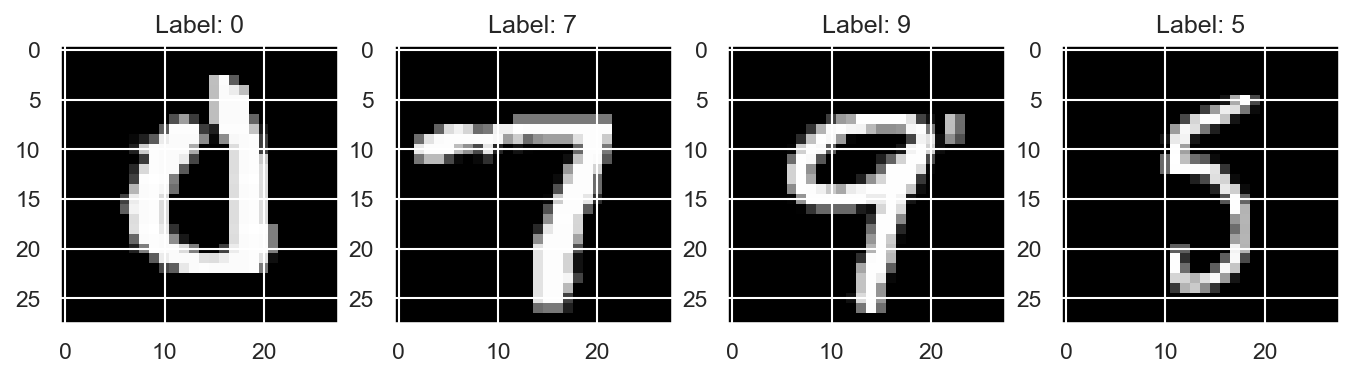

In [363]:
batch_size = 64

# Load Data
train_dataset = datasets.MNIST(root='dataset/', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(root='dataset/', train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

# Visualise data
# Create layout
fontsize = 14
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 1200 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 4)

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))
axes.append(plt.Subplot(fig, outer[3]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

images, labels = next(iter(train_loader))
for ida, ax in enumerate(axes):
    ax.imshow(images[ida][0], cmap='gray')
    ax.set_title('Label: %d' % labels[ida])
plt.show()

The data consists of images (32x32 pixels) and corresponding labels. If we want to use our simple network from above to classify the images, we need it to take an image as input (i.e. 32x32 = 784 input signals) and output the class label. However, so far out model only predicts values between 0 and 1, making the mapping of the output to the class labels challenging.

A common way to solve multi-class classification is to use a second layer that takes the inputs from the previous layer and processes them to several outputs -- one output for each class. If those outputs are normalised, they can be interpreted as the model's confidence for the classification.

### Task 11: Amend the single-layer perceptron to have 10 outputs instead of 1

Use the second layer to process the output of the first layer and return 10 outputs. Test you implementation by training the model on the data using the cell below. If you implemented the model correctly, it should achieve a test accuracy of >95%.

In [370]:
class NeuralNetwork2(nn.Module):
    def __init__(self, n_inputs=784, n_perceptrons=64, n_classes=10):
        super(NeuralNetwork2, self).__init__()
        self.layer1 = nn.Linear(n_inputs, n_perceptrons)
        self.layer2 = nn.Linear(n_perceptrons, n_classes)

    def forward(self, x):
        # Perceptron activation (now using sigmoid)
        out = F.relu(self.layer1(x))

        # TODO: Process the output with the second layer
        y = self.layer2(out)

        return y

In [371]:
# Train Network
input_size = 784
num_classes = 10
learning_rate = 0.001
num_epochs = 5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NeuralNetwork2(
    n_inputs=input_size, n_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    print(f'Epoch: {epoch}')

    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device=device)
        targets = targets.to(device=device)

        data = data.reshape(data.shape[0], -1)  # Flatten
        scores = model(data)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()  # set all gradients to zero for each batch
        loss.backward()

        # gradient descent
        optimizer.step()

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4


In [372]:
def check_accuracy(loader, model):

    if loader.dataset.train:
        print("Accuracy on training data")
    else:
        print("Accuracy on testing data")

    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():  # dont compute gradients
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            x = x.reshape(x.shape[0],-1)

            scores = model(x)
            _, predictions = scores.max(1)

            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(f'Got {num_correct}/{num_samples} with accuracy {float(num_correct)/float(num_samples)*100: .2f}')

    model.train()


check_accuracy(train_loader, model)
check_accuracy(test_loader, model)

Accuracy on training data
Got 58664/60000 with accuracy  97.77
Accuracy on testing data
Got 9692/10000 with accuracy  96.92


Amazing! You just trained your first MLP and achieved an amazing image classification accuracy of >95% on a test dataset that the model has never seen before! So we really start to see how we can use networks of simple artificial neurons to achieve very complex tasks.

In fact, one can prove that MLPs can lean to solve any task perfectly that can be formulated in terms of an input-output relationship, i.e. a function, and sufficient data is available. Here, the function that we are trying to learn from the data is the probability mass function over the digits conditional on the input image

<img src="Picture_1.png" width="350" style="display: block; margin: 0 auto">
<img src="Picture_2.png" width="350" style="display: block; margin: 0 auto">

For some images, the digit is simple to identify and the model is expected to assign all probability mass to the corresponding digit class. For others, the handwriting might be more difficult to decipher and the probablity should be spread across the class labels more evenly.

Formally, the probablity mass function can be denoted by
$$
p(y| x) \approx f(y | x, w),
$$
where $y$ denotes the digit and $x$ denotes the image. 




To demonstrate that MLPs can, in fact, achieve much more complex tasks than the network that we have used before, ...

<img src="multi_layer_perceptron_network.avif" width="700" style="display: block; margin: 0 auto">

While MLPs get closer to biological brains, in the sense that they use cascades of neurons to process information, it is certainly a stretch to expect MLPs to diplay intelligent behaviour. Nevertheless, a remarkable property of MLPs is that they are **universal function approximators** (arguably, the real reason why artifical "intelligence" has been so successful in the last decade).

Universal function approximator means that MLPs can perfectly describe any function, provided: 1. we have sufficient data from the function; and 2. the MLP has sufficiently many artificial neurons in each layer. For more details, google "Universal function approximation theorem".